In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os


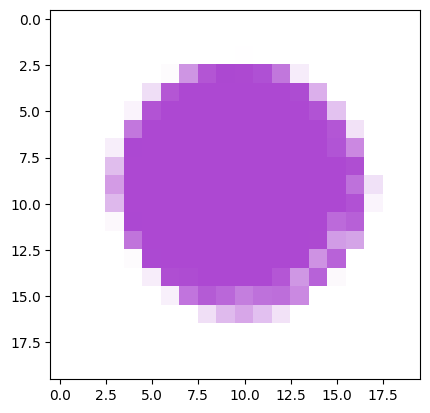

In [56]:
img = Image.open("gifs/4.gif")

arr = np.array(img)

blue_c = arr[259:279, 32:52, :]
Image.fromarray(blue_c).save("pink.png")

plt.imshow(arr[259:279, 32:52, :])

In [12]:
def getCoords(img, template, find_num):
    List = []
    w, h = template.shape[0], template.shape[1]

    showImg = img.copy()

    result = cv2.matchTemplate(img,template, cv2.TM_CCOEFF_NORMED)
    # get find_num best matches
    loc = np.where(result >= np.sort(result.flatten())[-find_num])
    

    for i in zip(*loc[::-1]):
        location = (i[0] + w, i[1] + h)
        List.append([i, location])

        cv2.rectangle(showImg, i, location, 255, 0)

    List = sorted(List, key=lambda x: x[0][1])

    plt.imshow(showImg)
    plt.show()
    return List

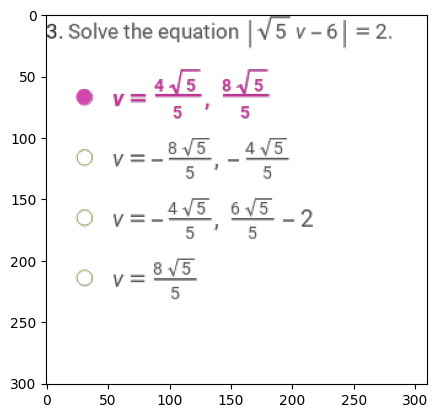

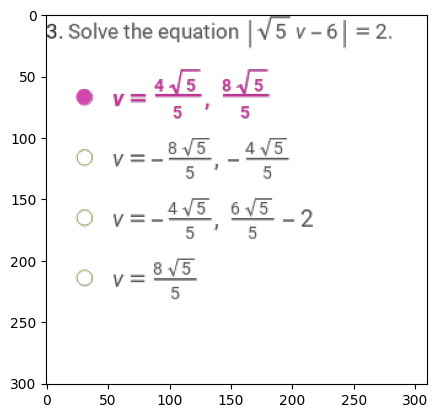

3 1


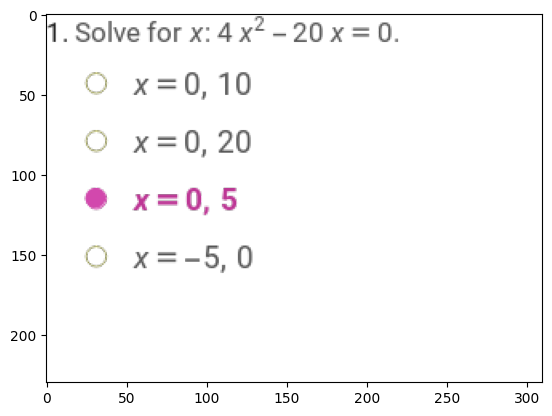

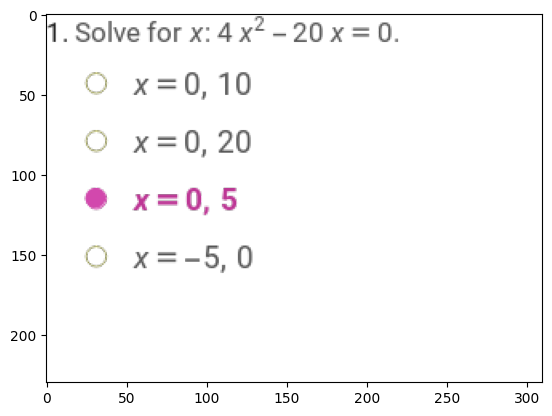

3 1


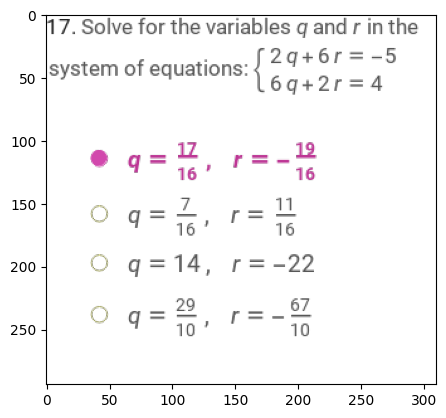

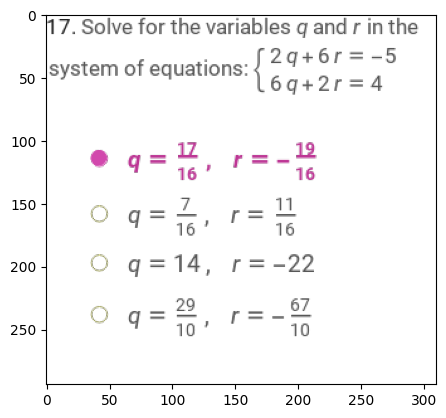

3 1


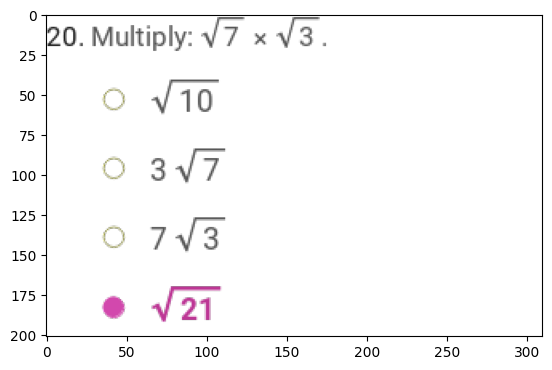

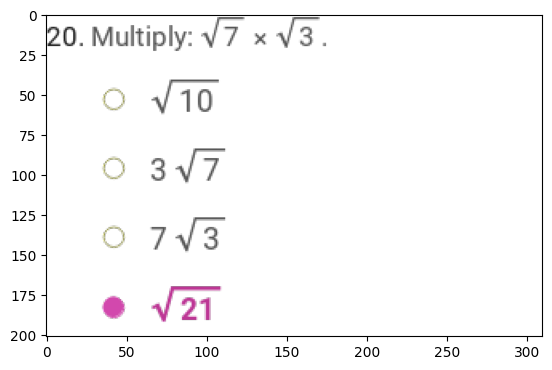

3 1


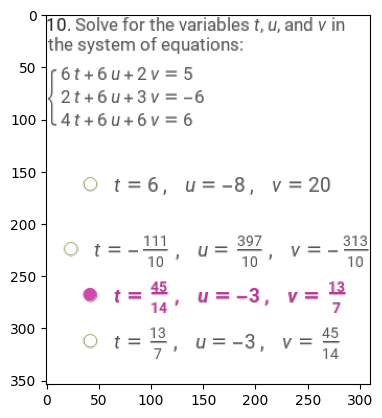

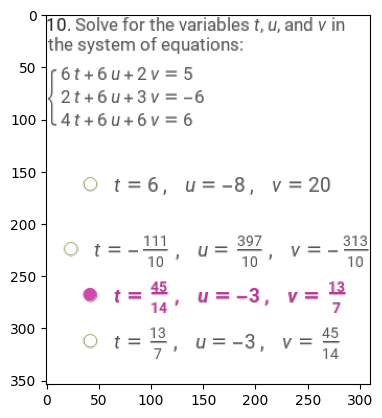

3 1


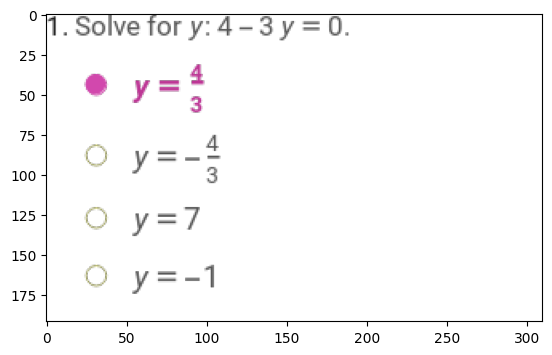

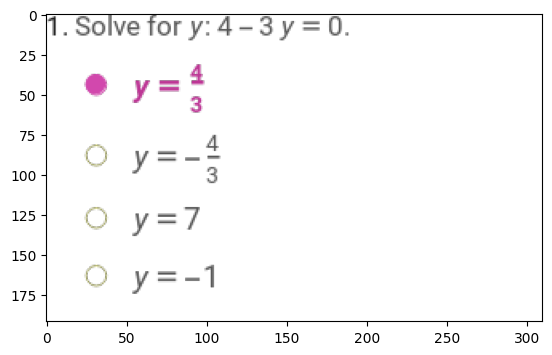

3 1


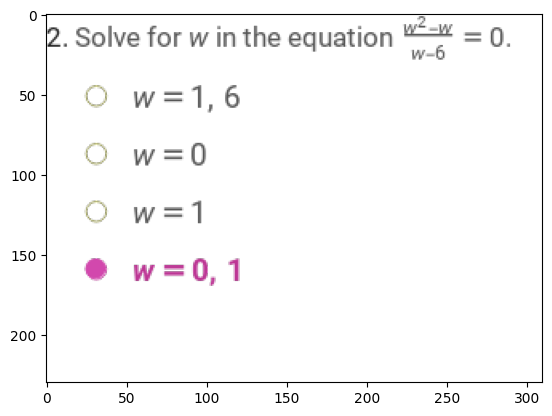

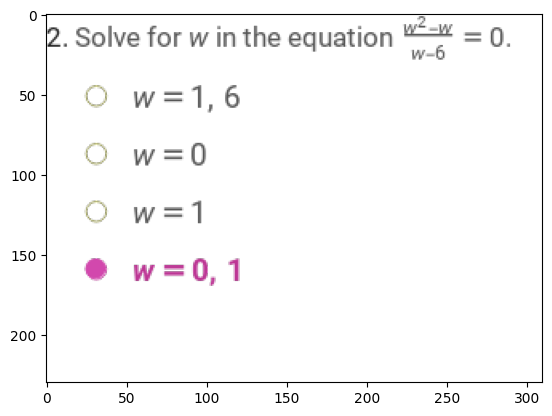

3 1


In [16]:
gifs = os.listdir("gifs")
# rm -rf processedImgs
os.system("rm -rf processedImgs")
os.mkdir("processedImgs")

for gif in gifs:
    img = cv2.imread(f'gifs/{gif}',-1)
    blue_template = cv2.imread('blue.png',-1)
    pink_template = cv2.imread('pink.png',-1)

    img_w, img_h = img.shape[1], img.shape[0]

    blueCoord = getCoords(img, blue_template, 3)
    pinkCoord = getCoords(img, pink_template, 1)
    print(len(blueCoord), len(pinkCoord))
    

    solution_idx = 0
    for coord in blueCoord:
        if pinkCoord[0][0][1] > coord[0][1]:
            solution_idx += 1
        else:
            break

    os.mkdir(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}")

    allCoord = [[(int(0.05*img_h), int(0.05*img_h)), (int(0.05*img_h), int(0.05*img_h))]] + blueCoord[:solution_idx] + pinkCoord + blueCoord[solution_idx:] + [[(img_h, img_h), (img_h, img_h)]]

    for i in range(len(allCoord) - 1):
        lower_coord = allCoord[i][0][1] - int(0.05 * img_h)
        upper_coord = allCoord[i+1][0][1] - int(0.05 * img_h)

        if i == 0:
            img_block = img[lower_coord:upper_coord, 0:img_w]

        else:
            img_block = img[lower_coord:upper_coord, allCoord[i][1][0]+2:img_w]

        ret,thresh = cv2.threshold(img_block,20,255,cv2.THRESH_BINARY)
        white_pt_coords=np.argwhere(thresh)
        min_y = min(white_pt_coords[:,0])
        min_x = min(white_pt_coords[:,1])
        max_y = max(white_pt_coords[:,0])
        max_x = max(white_pt_coords[:,1])

        crop = img_block[
            max(0, min_y-2):min(max_y+2, img_block.shape[0]),
            max(0, min_x-2):min(max_x+2, img_block.shape[1])
        ]
        
        # plt.imshow(crop)
        # plt.show()
        
        crop = Image.fromarray(crop).convert("LA")

        if i == 0:
            crop.save(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}/q.png")
        else:
            crop.save(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}/a{i}.png")

In [10]:
Image.open("gifs/1.gif").save("gifs/1.png")

img = cv2.imread('gifs/1.png', -1)
img = Image.fromarray(img)
img.save('gifs/1.png')